# I. Elastic Constants Calculations Based on Strain Fluctuations Method (compied from Penghua Ying)

## II. Introduction
- In this example, we calculate the elastic constants of diamond Si at 300 K and zero pressure. Based on the strain fluctuations method [[Parrinello 1982]](https://doi.org/10.1063/1.443248), one can directly measure the elastic constants from the fluctuations of unit cell vectors in the constant-stress (N, $\sigma$, T) molecular dynamics simulations:
$$
C_{ijkl}^{-1} = \frac{V}{k_{B}T}(\left\langle\epsilon_{ij}\epsilon_{kl}\right\rangle-\left\langle\epsilon_{ij}\right\rangle\left\langle\epsilon_{kl}\right\rangle),
$$
where $\epsilon$ is the unit cell strain, $V$ is the unit cell volume, $T$ is the temperature and $k_{B}$ is the Boltzmann constant. $\left\langle\right\rangle$ represents the ensemble average and calculated as the the average over a period of time in molecular dynamics simulations. 


- In this tutorial, we use the stochastic cell rescaling (scr) ensemble [[Bernetti 2020]](https://doi.org/10.1063/5.0020514), which is a first-order barostat that samples the correct volume fluctuations by including a suitable noise term. The scr ensemble has been implemented in GPUMD recently. However, we stress that the strain fluctuation methods **cannot** be performed using **the Berendsen method**, due to the fact that the Berendsen method cannot give the correct volume fluctuations. 

## II. Prepare inputs

### III. Structure model

[Here](../250720-1u0_model.xyz/333-FeCo-CONTCAR.xyz) is the `model.xyz`, a cubic FeCo superscell including around 10000 atoms. 

### III. `run.in`

It reads:

```
potential  /home/wangy43/codes_inst_loca/nep_pote_lib/SongKK-FeCoWRe250720_nep/SongKK-FeCoWRe250720_nep.txt

velocity    $i      # i = 300, 700, 1100 K    

ensemble    npt_scr 300 300 100 0 0 0 0 0 0 100 100 100 100 100 100 1000
time_step   1
dump_thermo  100
dump_exyz       100000 1 1 1         
run       1000000

ensemble    npt_scr 300 300 100 0 0 0 0 0 0 100 100 100 100 100 100 1000
time_step   1
dump_thermo  100
dump_exyz       100000 1 1 1         
run       1000000

```

## II. Run python script for elastic constant calculations

`1_calc-finite-T-elastic_fr-gpumd-thermo.py` reads: 

In [39]:
from thermo.gpumd.data import load_thermo
import numpy as np
import os
from pylab import *
import math


def calc_angle(v1, v2):
    alpha = math.acos(np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2)))
    return alpha


def calc_elstic(strain_ij, strain_kl):
    s_ijkl = average(strain_ij * strain_kl) - average(strain_ij) * average(strain_kl)
    return s_ijkl


def output_elastic_gpumd(path, temperature, slice_num):
    thermo = load_thermo(directory=path)
    for keys in thermo:
        thermo[keys] = thermo[keys][10000:]  # Discard the first 100 ps data
    Cij = np.zeros((slice_num, 3))
    M = np.zeros((slice_num, 4))
    for i in range(slice_num):
        thermo_slice = dict()
        for keys in thermo:
            thermo_slice[keys] = thermo[keys][1000 * i:1000 * (i + 1)]
        alpha = np.zeros(len(thermo_slice["ax"]))
        beta = np.zeros_like(alpha)
        gamma = np.zeros_like(alpha)
        for j in range(len(thermo_slice["ax"])):
            va = [thermo_slice["ax"][j], thermo_slice["ay"][j], thermo_slice["az"][j]]
            vb = [thermo_slice["bx"][j], thermo_slice["by"][j], thermo_slice["bz"][j]]
            vc = [thermo_slice["cx"][j], thermo_slice["cy"][j], thermo_slice["cz"][j]]
            alpha[j] = calc_angle(vb, vc)
            beta[j] = calc_angle(va, vc)
            gamma[j] = calc_angle(va, vb)

        strain = dict()
        strain["11"] = thermo_slice["ax"] / average(thermo_slice["ax"]) - 1  # xx
        strain["22"] = thermo_slice["by"] / average(thermo_slice["by"]) - 1  # yy
        strain["33"] = thermo_slice["cz"] / average(thermo_slice["cz"]) - 1  # zz
        strain["23"] = (alpha - pi / 2) / 2  # yz
        strain["13"] = (beta - pi / 2) / 2  # xz
        strain["12"] = (gamma - pi / 2) / 2  # xy

        V = average(thermo["ax"] * thermo["by"] * thermo["cz"])  # volume
        T = temperature  # temperature in K
        kB = 1.38064852  # unit in e-23 J/K
        scale = 100 / (T * kB) * V  # unit in GPa^{-1}

        S1111 = scale * calc_elstic(strain["11"], strain["11"])
        S2222 = scale * calc_elstic(strain["22"], strain["22"])
        S3333 = scale * calc_elstic(strain["33"], strain["33"])
        S1122 = scale * calc_elstic(strain["11"], strain["22"])
        S1133 = scale * calc_elstic(strain["11"], strain["33"])
        S2233 = scale * calc_elstic(strain["22"], strain["33"])
        S2323 = scale * calc_elstic(strain["23"], strain["23"])
        S1313 = scale * calc_elstic(strain["13"], strain["13"])
        S1212 = scale * calc_elstic(strain["12"], strain["12"])

        S11 = (S1111 + S2222 + S3333) / 3
        S12 = (S1122 + S1133 + S2233) / 3
        S44 = 4 * (S2323 + S1313 + S1212) / 3

        Spq = np.array([[S11, S12, S12, 0, 0, 0],
                        [S12, S11, S12, 0, 0, 0],
                        [S12, S12, S11, 0, 0, 0],
                        [0, 0, 0, S44, 0, 0],
                        [0, 0, 0, 0, S44, 0],
                        [0, 0, 0, 0, 0, S44]])

        Cpq = np.linalg.inv(Spq)
        C11 = Cpq[0, 0]
        C12 = Cpq[0, 1]
        C44 = Cpq[3, 3]

        Cij[i] = np.array([C11, C12, C44])

        Kv = (3*C11 + 2*3*C12) / 9
        Gv = (3*C11 - 3*C12 + 4*3*C44) / 15
        E = (9*Kv*Gv) / (3*Kv + Gv)
        nu = (3*Kv - 2*Gv) / (2*(3*Kv + Gv))

        M[i] = np.array([Kv, Gv, E, nu])

    return Cij, M


def calc_ste(array):
    ste = np.zeros(array.shape[1])
    for i in range(array.shape[1]):
        ste[i] = sqrt(sum(abs(array[:, i] - array[:, i].mean()) ** 2)) / len(array[:, i])
    return ste


results_C = []
results_M = []
temperatures = [300, 700, 1100]

for T in temperatures:
    dire = f"job_{T}_1_1"
    Cij_T, M_T = output_elastic_gpumd(dire, T, 10)

    mean_Cij = np.average(Cij_T, axis=0)
    ste_Cij = calc_ste(Cij_T)

    mean_M = np.average(M_T, axis=0)
    ste_M = calc_ste(M_T)

    results_C.append([T, *mean_Cij, *ste_Cij])
    results_M.append([T, *mean_M, *ste_M])

results_C = np.array(results_C)
results_M = np.array(results_M)

os.makedirs("result-elastic", exist_ok=True)

with open("result-elastic/elastic-vs-temperature.txt", "w") as f:
    f.write("# T  C11  C12  C44  C11-ste  C12-ste  C44-ste\n")
    for row in results_C:
        f.write("{:6} {:12.6f} {:12.6f} {:12.6f} {:12.6f} {:12.6f} {:12.6f}\n".format(*row))

with open("result-elastic/module-vs-temperature.txt", "w") as f:
    f.write("# T  Kv  Gv  E  nu  Kv-ste  Gv-ste  E-ste  nu-ste\n")
    for row in results_M:
        f.write("{:6} {:12.6f} {:12.6f} {:12.6f} {:12.6f} {:12.6f} {:12.6f} {:12.6f} {:12.6f}\n".format(*row))

print("Results saved in result-elastic/elastic-vs-temperature.txt and result-elastic/module-vs-temperature.txt")


/home/wyz/venvpy/shellpy-regular/lib/python3.12/site-packages/thermo/gpumd/data.py:335: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(thermo_path, delim_whitespace=True, header=None)
/home/wyz/venvpy/shellpy-regular/lib/python3.12/site-packages/thermo/gpumd/data.py:335: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(thermo_path, delim_whitespace=True, header=None)


Results saved in result-elastic/elastic-vs-temperature.txt and result-elastic/module-vs-temperature.txt


/home/wyz/venvpy/shellpy-regular/lib/python3.12/site-packages/thermo/gpumd/data.py:335: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(thermo_path, delim_whitespace=True, header=None)


## II. Plot elastic moduli

`2_postPlot_module-vs-T.py` reads: 

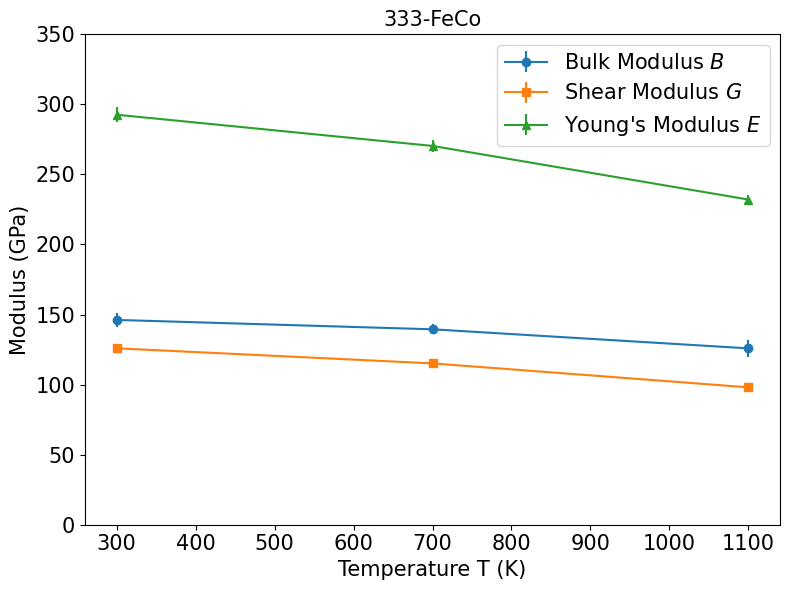

✅ Plot saved as result-elastic/module-vs-T.png


In [40]:
import numpy as np
import matplotlib.pyplot as plt

# 读取数据
filepath = "result-elastic/module-vs-temperature.txt"
data = []
with open(filepath, 'r') as f:
    for line in f:
        if line.startswith('#'):
            continue
        parts = line.split()
        data.append([float(x) for x in parts])

# 转换为 numpy 数组
data = np.array(data)

# 提取各列
T = data[:, 0]
Kv = data[:, 1]
Gv = data[:, 2]
E = data[:, 3]
Kv_ste = data[:, 5]
Gv_ste = data[:, 6]
E_ste = data[:, 7]

# 绘图
fs=15

plt.figure(figsize=(8,6))

plt.errorbar(T, Kv, yerr=Kv_ste, fmt='o-', color='tab:blue', label='Bulk Modulus ' + r"$B$")
plt.errorbar(T, Gv, yerr=Gv_ste, fmt='s-', color='tab:orange', label='Shear Modulus ' + r"$G$")
plt.errorbar(T, E, yerr=E_ste, fmt='^-', color='tab:green', label="Young's Modulus " + r"$E$")

plt.xlabel("Temperature T (K)",fontsize=fs)
plt.ylabel("Modulus (GPa)",fontsize=fs)
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)
plt.ylim([0,350])

plt.legend(fontsize=fs)
plt.title("333-FeCo", fontsize=fs)
plt.tight_layout()

plt.savefig("result-elastic/module-vs-T.png", dpi=200)
plt.show()

print("✅ Plot saved as result-elastic/module-vs-T.png")
